#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Исследование-заказов-в-течение-дня" data-toc-modified-id="Исследование-заказов-в-течение-дня-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Исследование заказов в течение дня</a></span></li><li><span><a href="#Исследование-заказов-в-течение-недели" data-toc-modified-id="Исследование-заказов-в-течение-недели-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Исследование заказов в течение недели</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-обучающего-дерева" data-toc-modified-id="Модель-обучающего-дерева-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Модель обучающего дерева</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-линейной-регресси" data-toc-modified-id="Модель-линейной-регресси-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Модель линейной регресси</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Выполним ресемплирование данных по одному часу:

In [4]:
data = data.resample('1H').sum()

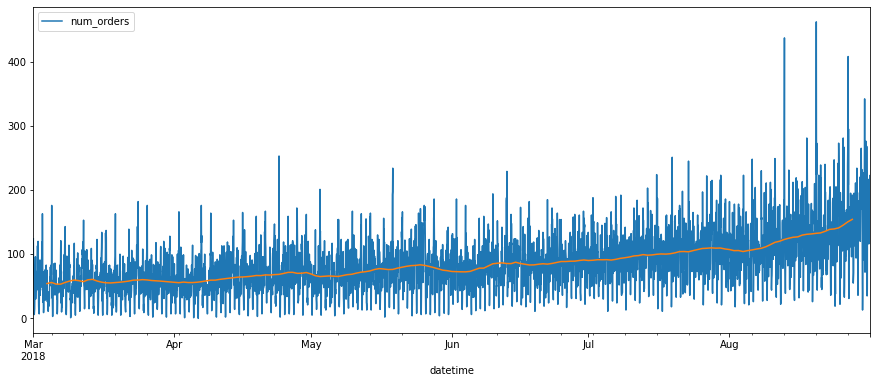

In [5]:
data.plot(figsize=(15, 6))

decomposed = seasonal_decompose(data['num_orders'].resample('1D').mean()) 
decomposed.trend.plot()
None

In [6]:
print(f'Данные за период {data.index.min().strftime("%d.%m")}-{data.index.max().strftime("%d.%m %Y")} года.')

Данные за период 01.03-31.08 2018 года.


Видно, что к концу периода количество поездок и их разброс увеличивается, что может сказаться на качестве обучения.

## Анализ

Рассмотрим тренды и сезонность для имеющихся данных.

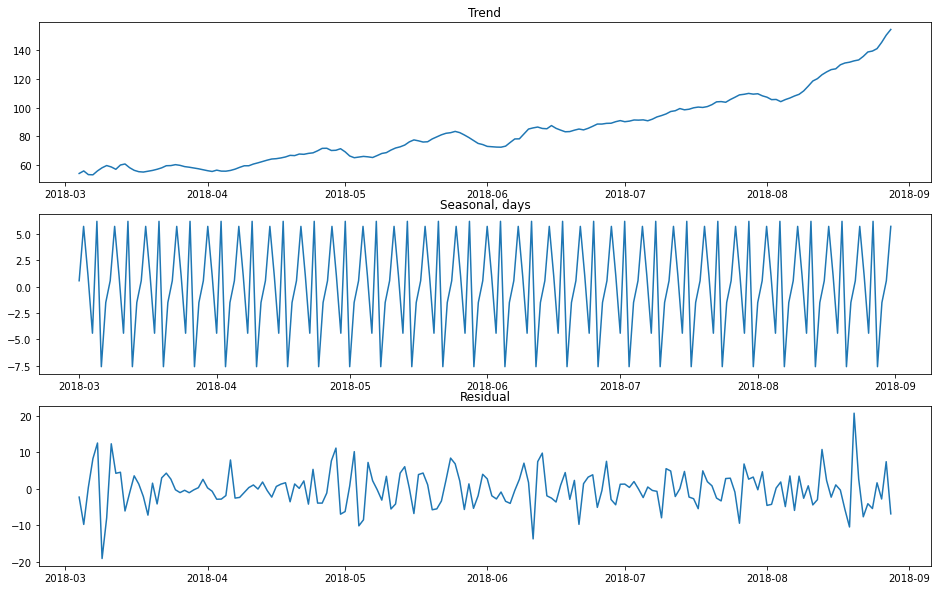

In [7]:
fig, axs = plt.subplots(3, figsize=(16,10), sharex=False)
axs[0].plot(decomposed.trend)
axs[0].set_title("Trend")

axs[1].plot(decomposed.seasonal)
axs[1].set_title("Seasonal, days")

axs[2].plot(decomposed.resid)
axs[2].set_title("Residual")
None

За несколько месяцев количество заказов у компании увеличилось. Это может быть как внутригодовой тренд, так и расширение компании. Так же заметна сезонность по дням. 
Исследуем подробнее особенности заказов в течение дня и недели.

### Исследование заказов в течение дня

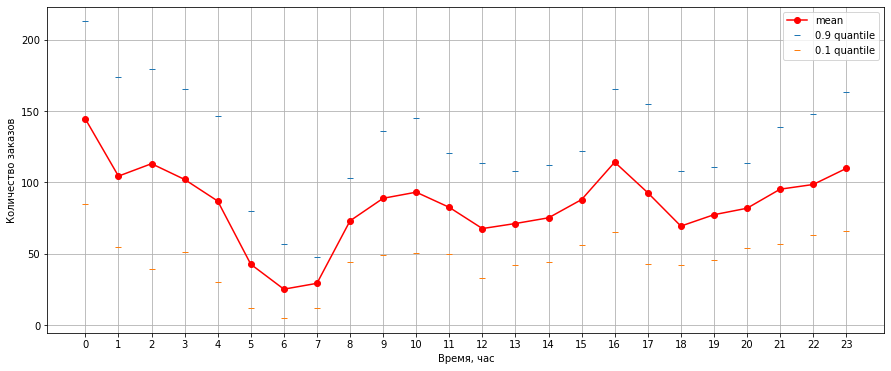

In [8]:
data['hour'] = data.index.hour

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(15)

data.groupby('hour')['num_orders'].mean().plot(grid=True, style='-', marker='o', color='r', ax=ax)
data.groupby('hour')['num_orders'].quantile(0.9).plot(grid=True, style='_', ax=ax)
data.groupby('hour')['num_orders'].quantile(0.1).plot(grid=True, style='_', ax=ax)

ax.set_xticks(range(24))
ax.legend(['mean', '0.9 quantile', '0.1 quantile'])
plt.xlabel('Время, час')
plt.ylabel('Количество заказов')

None

На графике представлено среднее значение количества заказов от времени, а так же 0.1 и 0.9 квантили. Наибольшее количество заказов в полночь и в 16 часов, а минимум находится в периоде 5-7 часов утра. В остальное время заказы распределены относительно равномерно.

### Исследование заказов в течение недели

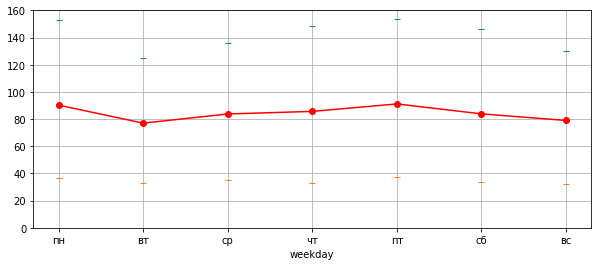

In [9]:
data['weekday'] = data.index.weekday

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(10)
data.groupby('weekday')['num_orders'].mean().plot(grid=True, style='-', marker='o', color='r', ax=ax)
data.groupby('weekday')['num_orders'].quantile(0.9).plot(grid=True, style='_', ax=ax)
data.groupby('weekday')['num_orders'].quantile(0.1).plot(grid=True, style='_', ax=ax)

plt.xticks(ticks=range(7), labels=['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])
ax.set_ylim([0, 160])
None

В среднем больше всего заказов в понедельник и пятницу. Однако в целом относительная разница невелика, поэтому можно предположить, что распределения за день мало зависят от дня недели.

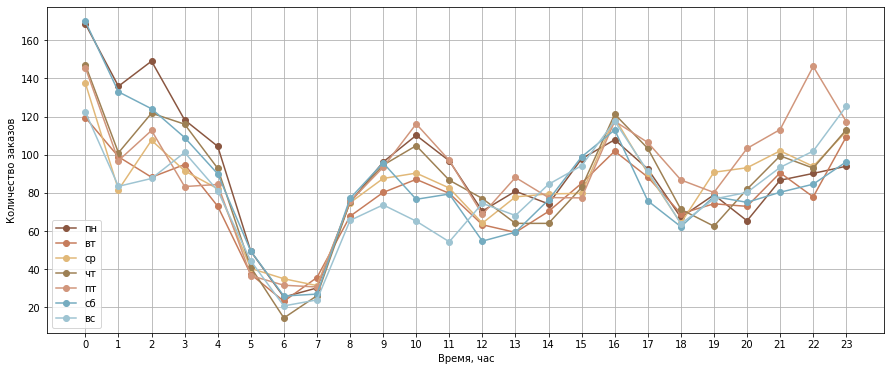

In [10]:
def day_plotter(data, weekday, ax, color):
    
    df = data.query('weekday == @weekday')
    df.groupby('hour')['num_orders'].mean().\
    plot(grid=True, style='-', marker='o', ax=ax, color=color)
    

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(15)

colors = ['#8a5640', '#c67c5c', '#e1b878', '#9d8054', '#d1967c', '#75ACC0', '#9ec4d2']
for weekday in range(7):
    day_plotter(data, weekday, ax, colors[weekday])   
    

ax.set_xticks(range(24))
ax.legend(['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])


plt.xlabel('Время, час')
plt.ylabel('Количество заказов')
None

Есть различия в распределениях, но форма повторяет осредненную. Так же нет принципиальной разницы между выходными днями и буднями.  

## Обучение

### Подготовка признаков

Введем в качестве признака значения скользящего среднего за сутки:

In [11]:
data['rolling_mean'] = data['num_orders'].rolling(24).mean().shift(1) 

Учтем предыдущие значения временного ряда, введя столбцы со значениями предыдущих часов. Чтобы опеделить достаточное количество часов учета, найдем автокорреляцию с промежутками от 0 до 24 часов:

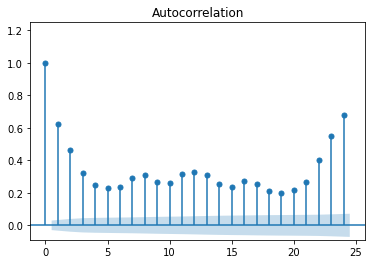

In [12]:
_ = plot_acf(data['num_orders'], lags=24, auto_ylims=True)

Видно, что за первые 5 часов значения стремительно уменьшаются. Важно отметить, что, во-первых, диаграмма почти симметрична, так как значения из суток в сутки в одно и то же время близки. Во-вторых, логично предположить, что в реальности влияние со временем уменьшается. Поэтому, несмотря на увеличение корреляции при периоде более 5 часов, ограничимся 5 предыдущими значениями.

In [13]:
for lag in range(1, 5):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

В результате мы имеем следущие данные:

**Целевой признак:**
- `num_orders` - количество заказов

**Признаки**
- `hour` - час
- `weekday` - день недели
- `rolling_mean` - скользящее среднее за сутки
- `lag_1`, `lag_2`- значения за предыдущие часы

Из всех данных выделим для тестовой и валидационной выборок по 10% данных:

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.2)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_train, target_train = shuffle(features_train, target_train, random_state=12345)
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

print('Обучающая выборка:')
print('   ', features_train.shape[0], 'строк')
print(f'    Данные за {features_train.index.min().strftime("%d.%m")}-\
{features_train.index.max().strftime("%d.%m %Y")} года')

print('\nТестовая выборка:')
print('   ', features_test.shape[0], 'строки')
print(f'    Данные за {features_test.index.min().strftime("%d.%m")}-\
{features_test.index.max().strftime("%d.%m %Y")} года')

Обучающая выборка:
    3508 строк
    Данные за 02.03-26.07 2018 года

Тестовая выборка:
    884 строки
    Данные за 26.07-31.08 2018 года


### Обучение моделей

In [15]:
def rmse_score(target, predictions):
    return mean_squared_error(target, predictions) ** 0.5

def rmse_check(rmse):
    if rmse > 48:
        print('Модель не удовлетворяет требованиям точности.')
    else:
        print('Модель удовлетворяет требованиям точности.')

In [16]:
def train_model(model, parameters, features, target):
    
    tscv = TimeSeriesSplit(n_splits=4)
    grid_search = GridSearchCV(model, parameters, cv=tscv, 
                               scoring=make_scorer(rmse_score)
                               )
    grid_search.fit(features, target)
    
    return grid_search, grid_search.best_params_, grid_search.best_score_

def printer(params, rmse):
    
    print('Параметры модели:')
    for key, value in params.items():
        print(f'  {key}: {value}')
    print('\nRMSE = ', int(rmse))
    rmse_check(rmse)    

#### Модель обучающего дерева

In [17]:
tree_model = DecisionTreeRegressor(random_state=12345)    
parameters = {'max_depth': list(range(2, 20))}

tree_model, tree_params, tree_rmse = train_model(tree_model, parameters, features_train, target_train)

printer(tree_params, tree_rmse)

summary = {}
summary['Дерево решений'] = int(tree_rmse)

Параметры модели:
  max_depth: 17

RMSE =  31
Модель удовлетворяет требованиям точности.


#### Модель случайного леса

In [18]:
forest_model = RandomForestRegressor(random_state=12345)    
parameters = {'max_depth': list(range(10, 30)),
              'n_estimators':list(range(10, 30))
             }

forest_model, forest_params, forest_rmse = train_model(forest_model, parameters, features_train, target_train)

printer(forest_params, forest_rmse)

summary['Случайный лес'] = int(forest_rmse)

Параметры модели:
  max_depth: 27
  n_estimators: 10

RMSE =  24
Модель удовлетворяет требованиям точности.


#### Модель линейной регресси

In [19]:
lr_model = LinearRegression()
parameters = {'fit_intercept':[True,False]
             }

lr_model, lr_params, lr_rmse = train_model(lr_model, parameters, features_train, target_train)

printer(lr_params, lr_rmse)

summary['Линейная регрессия'] = int(lr_rmse)

Параметры модели:
  fit_intercept: True

RMSE =  29
Модель удовлетворяет требованиям точности.


### Выводы

В рамках данного этапа были созданы признаки для обучения. Данные были разделены на обучающую, валидационную и тестовую выборки. Обучены 3 модели: дерево решений, случайный лес и линейная регрессия, и для каждой из них подобраны гиперпараметры для улучшения качества предсказаний.

In [20]:
pd.DataFrame(summary.values(),
             index=summary.keys(),
             columns=['RMSE']
            )

,RMSE
Дерево решений,31
Случайный лес,24
Линейная регрессия,29


Все модели удовлетворяют требованиям точности на валидационной выборке. Для дальнейшего тестирования используем модель с лучшим значением RMSE.

In [21]:
model = RandomForestRegressor(random_state=12345, **forest_params)
model.fit(features_train, target_train)

None

## Тестирование

In [22]:
predictions = model.predict(features_test)
rmse = rmse_score(target_test, predictions)

print('RMSE =', int(rmse))
rmse_check(rmse)

RMSE = 43
Модель удовлетворяет требованиям точности.


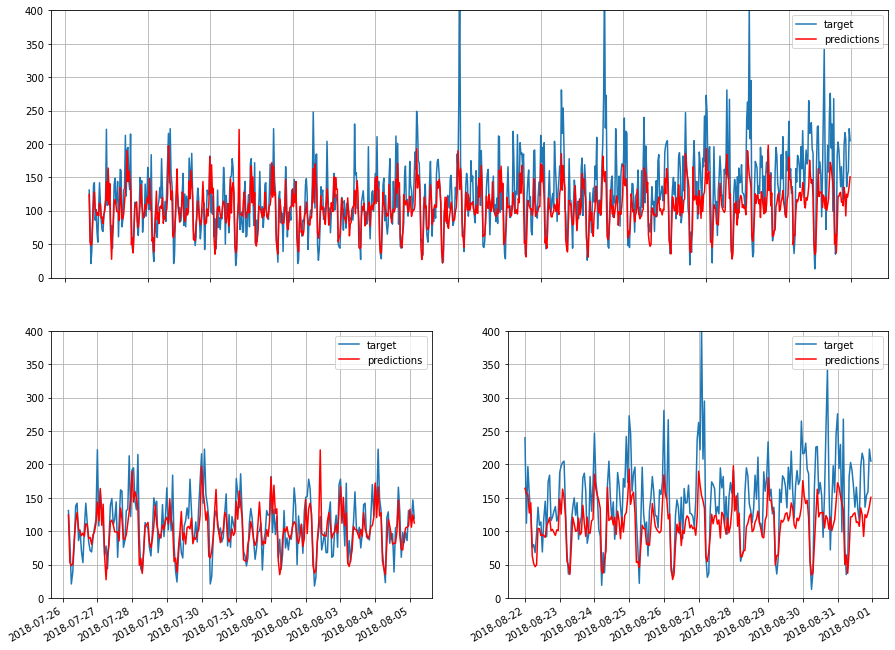

In [23]:
fig, ax = plt.subplot_mosaic([['full','full'],
                             ['start', 'end']]
                            )
fig.set_figheight(12)
fig.set_figwidth(15)

def format_plot(target_test, predictions, ax):

    ax.plot(target_test)
    ax.plot(pd.Series(predictions, index=target_test.index), 
             color='r')
    ax.legend(['target', 'predictions'])
    ax.grid()
    ax.set_ylim([0,400])
    
format_plot(target_test, predictions, ax['full'])
format_plot(target_test[:240], predictions[:240], ax['start'])
format_plot(target_test[-240:], predictions[-240:], ax['end'])
fig.autofmt_xdate()
None

Предсказанные моделью значения, как правило, меньше, чем реальные. Так же разброс предсказанных значений меньше. Так же видно, что по мере удаления от периода, для которого проводилось обучение, качество предсказаний ухудшается.

## Выводы

В рамках проекта была выполненанализ данных: исследованы зависимости количества заказов от времени, дня недели, определен общий тренд. На основе анализа подготовлены признаки для будущего обучения модели. 

В качестве потенциальных моделей рассмотрены модели решающего дерева, случайного леса и логистической регрессии. Для каждой из них были подобраны гиперпараметры для улучшения качества. 

На основе значений RMSE на валидационных выборках была выбрана рабочая модель. После проверки на тестовой выборке было получено значение RMSE = 43, что меньше требуемых 48.